In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Base_Files.ClassLevyJumpProcesses import TemperedStableSubordinator
import GPy
from Base_Files.Creating_the_NGP import GaussianProcess


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


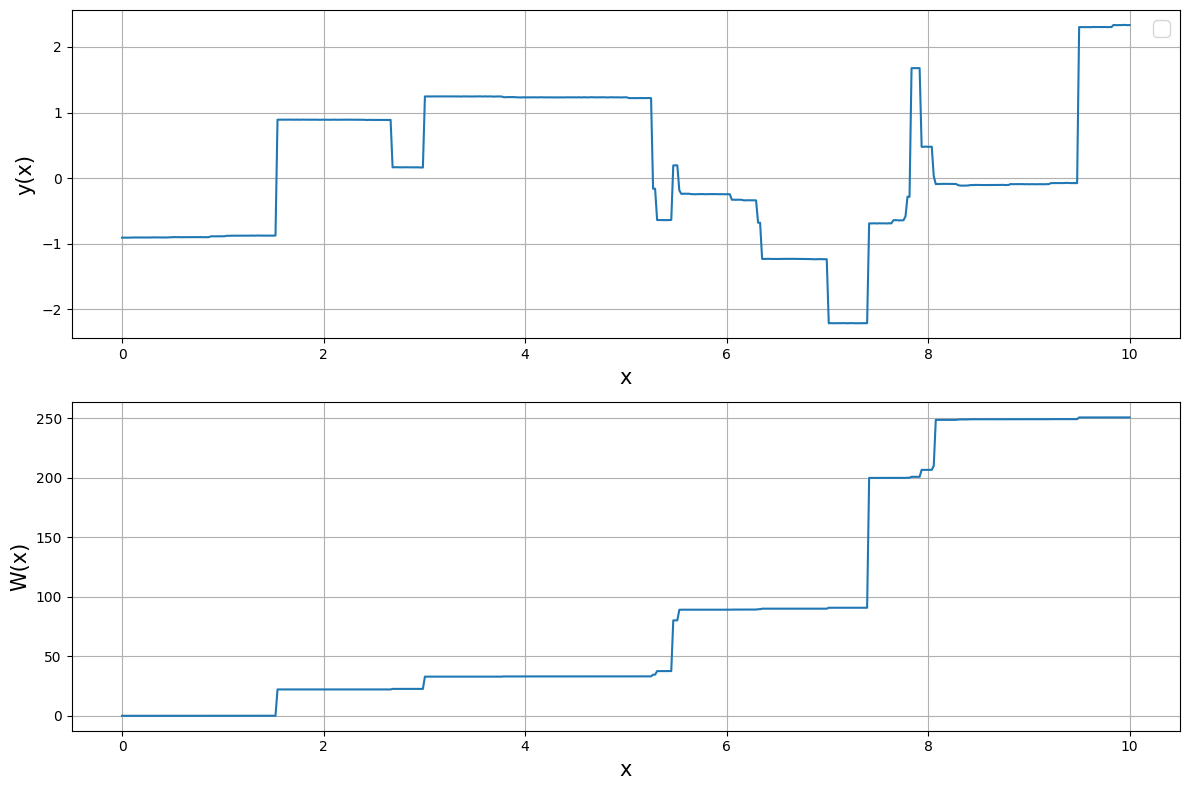

In [7]:
# Set Parameters
t1 = 0.0
t2 = 10.0

num_obs = 500 # (N) number of points e.g. size of data set
num_epochs = 2000
subordinator_truncation = 0.0
kappa = 0.2
delta = 1.2
gamma = 0.3
nProcesses = 1
l = 1

initial_sub = TemperedStableSubordinator(t1, t2, num_obs, num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
X = initial_sub
Y = GaussianProcess(initial_sub, 1, num_obs).reshape(-1,1)

Xs = np.linspace(0.0, 10.0, num_obs).reshape(-1, 1)

fig, ax = plt.subplots(nrows=2, figsize=(12,8))

ax[0].plot(Xs, Y)
ax[0].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('y(x)', fontsize=15)
ax[0].grid(True)
ax[0].legend(fontsize=15)

ax[1].plot(Xs, initial_sub)
ax[1].set_xlabel('x', fontsize=15)
ax[1].set_ylabel('W(x)', fontsize=15)
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [8]:
def log_likelihood(X, Y):
    kernel = GPy.kern.RBF(input_dim=1)
    sub_kernel = GPy.kern.Brownian(input_dim=1)
    model = GPy.models.GPRegression(X, Y, kernel*sub_kernel)
    log_likelihood = model.log_likelihood()
    return log_likelihood

num_iter = 2500
burn_in = 0

Number of accepted likelihood samples: 9
Accepted Likelihood samples: [-556.067497074302, -557.0386153788799, -555.724755152623, -551.934423104852, -547.8278785494333, -536.9378259528962, -536.3880887526468, -534.6689805925749, -528.3536335401703]
Accepted Alphas: [2732595.6557624056, 0.3786593447597481, 3.720508030342294, 44.27109795507395, 60.73648300078635, 53640.12118048555, 1.732797579253789, 5.579550179058562, 552.9939451710426]
-536.6408312554244


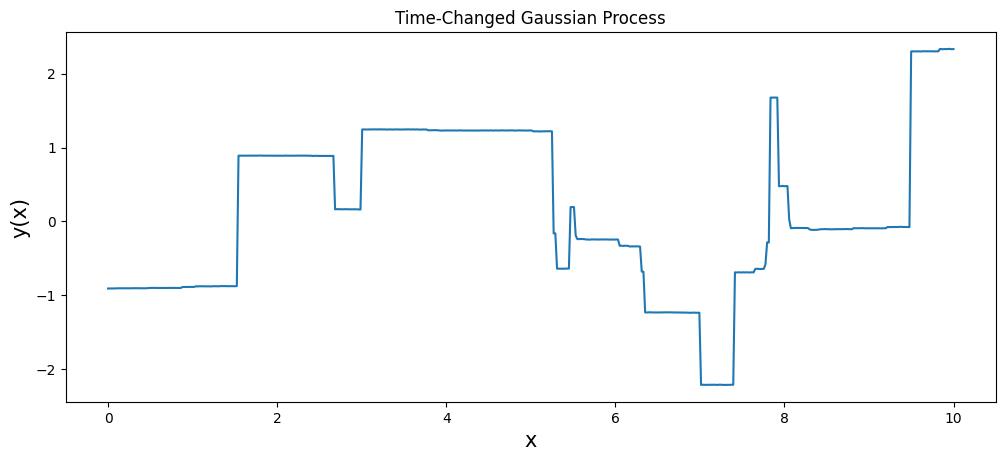

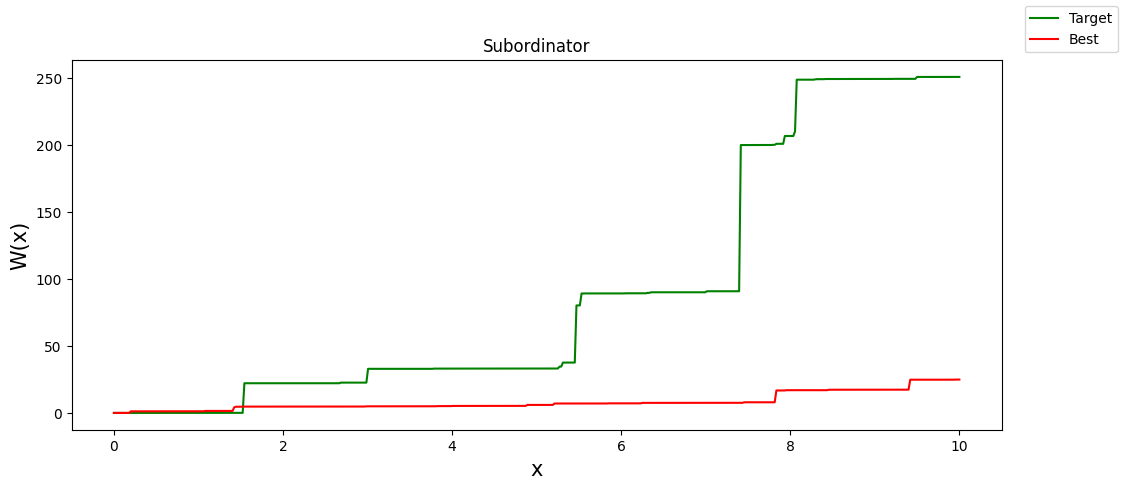

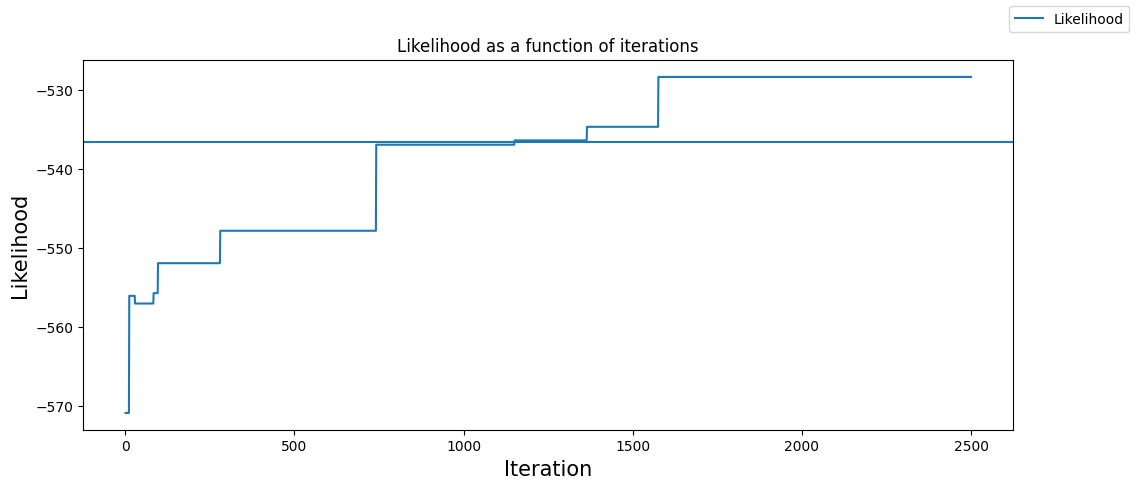

In [9]:
# Run the Metropolis-Hastings algorithm
t1 = 0.0
t2 = 10.0

N = 1

current_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
acceptances = 0

accept_sub_samples = []

likelihood_samples = []
accept_likelihood_samples = []

alphas = []
accept_alphas = []


for i in range(num_iter):
    # Draw a new proposal from the proposal distribution
#     print('Iteration:', i+1)

    new_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
    log_alpha = log_likelihood(new_sub, Y) - log_likelihood(current_sub, Y)
    alpha = np.exp(log_alpha)

    accept = np.random.uniform() < alpha
    alphas.append(alpha)

    if accept:
        current_sub = new_sub

        acceptances += 1

        accept_likelihood_samples.append(log_likelihood(current_sub, Y))

        accept_alphas.append(alpha)

        accept_sub_samples.append(current_sub)

    likelihood_samples.append(log_likelihood(current_sub, Y))


# Print the acceptance rate
#print('Acceptance rate:', acceptances*100 / num_iter, '%')
print('Number of accepted likelihood samples:', acceptances)
print('Accepted Likelihood samples:', accept_likelihood_samples)
print('Accepted Alphas:', accept_alphas)
print(log_likelihood(X, Y))

Xs = np.linspace(0, 10, int(num_obs/N))

plt.figure(1).set_figwidth(12)
plt.xlabel('x', fontsize=15)
plt.ylabel('y(x)', fontsize=15)
plt.title('Time-Changed Gaussian Process')
plt.plot(Xs, Y)

plt.figure(2).set_figwidth(12)
plt.plot(Xs, initial_sub, label='Target', color='green')
plt.plot(Xs, accept_sub_samples[-1], label='Best', color='red')
plt.title('Subordinator')
plt.xlabel('x', fontsize=15)
plt.ylabel('W(x)', fontsize=15)
plt.figure(2).legend()

plt.figure(3).set_figwidth(12)
plt.plot(np.linspace(1, len(likelihood_samples), len(likelihood_samples)), likelihood_samples, label='Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(3).legend()


plt.show()



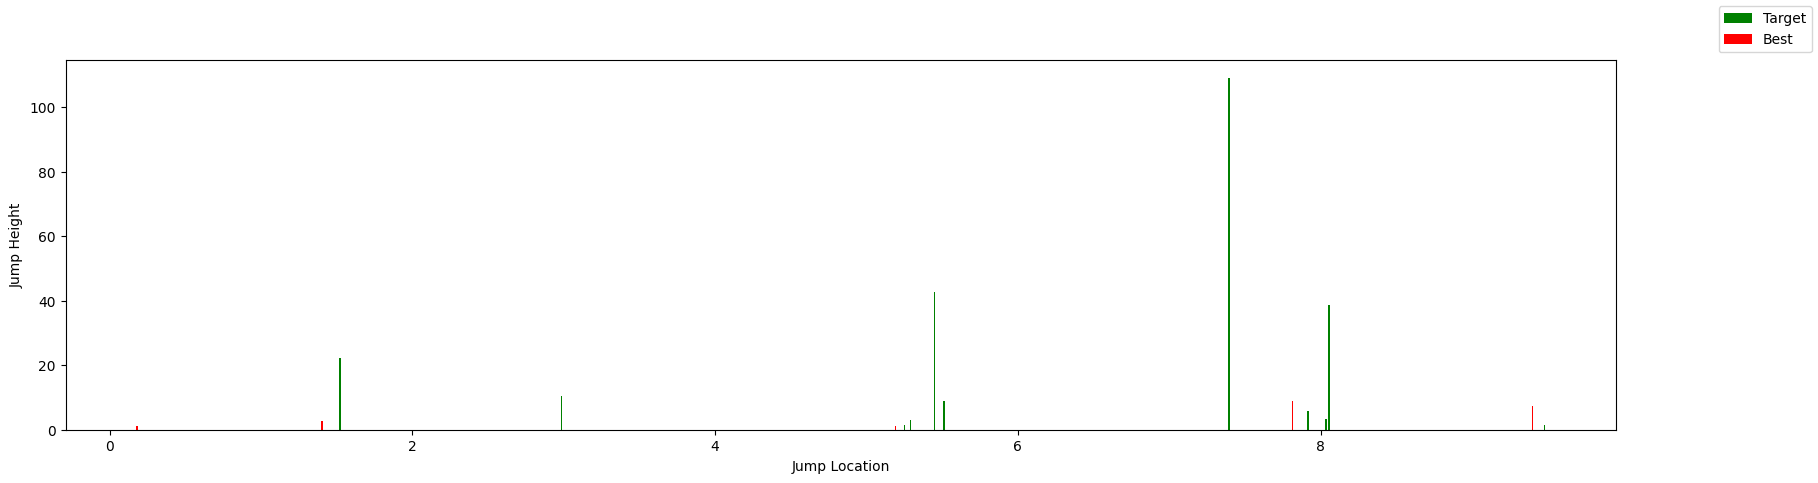

In [10]:
X_jump = []
Y_jump = []
X1_jump= []
Y1_jump= []

length = len(initial_sub)

for i in range(length-1):
    difference = 1
    if initial_sub[i+1] - initial_sub[i] > difference:
        X_jump.append(Xs[i])
        Y_jump.append((initial_sub[i+1] - initial_sub[i])[0])

    if accept_sub_samples[-1][i+1] - accept_sub_samples[-1][i] > difference:
        X1_jump.append(Xs[i])
        Y1_jump.append((accept_sub_samples[-1][i+1] - accept_sub_samples[-1][i])[0])

plt.figure(3).set_figwidth(20)
plt.bar(X_jump,Y_jump, width = 0.01, color='green', label='Target')
plt.bar(X1_jump,Y1_jump, width = 0.01, color='red', label='Best')
plt.xlabel('Jump Location')
plt.ylabel('Jump Height')
plt.figure(3).legend()

t1 = 0.0
t2 = 5.0

current_sub = TemperedStableSubordinator(t1, t2, int(num_obs/2), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
print(len(current_sub))
print(current_sub[-1])
print(accept_sub_samples[-1][-1])
print(abs(accept_sub_samples[-1][250]-current_sub[-1]))

diff = current_sub[-1] - accept_sub_samples[-1][250]
addon = accept_sub_samples[-1][250:] + diff

total = np.concatenate((current_sub, addon))

plt.plot(np.linspace(0, 5, int(num_obs/2)), current_sub)
plt.plot(np.linspace(5, 10, int(num_obs/2)), accept_sub_samples[-1][250:])
plt.plot(np.linspace(5, 10, int(num_obs/2)), addon)
plt.plot(np.linspace(0, 10, int(num_obs)), total)
plt.show()

Number of accepted likelihood samples: 6
Accepted Likelihood samples: [-525.9957060917017, -523.2298684741432, -523.2086548731274, -522.958471378078, -522.579189506781, -521.1487521724544]
Accepted Alphas: [10.569023890632812, 15.892346125268816, 1.0214402090036059, 1.2842610506132286, 1.4612348578649728, 4.1805270801904095]


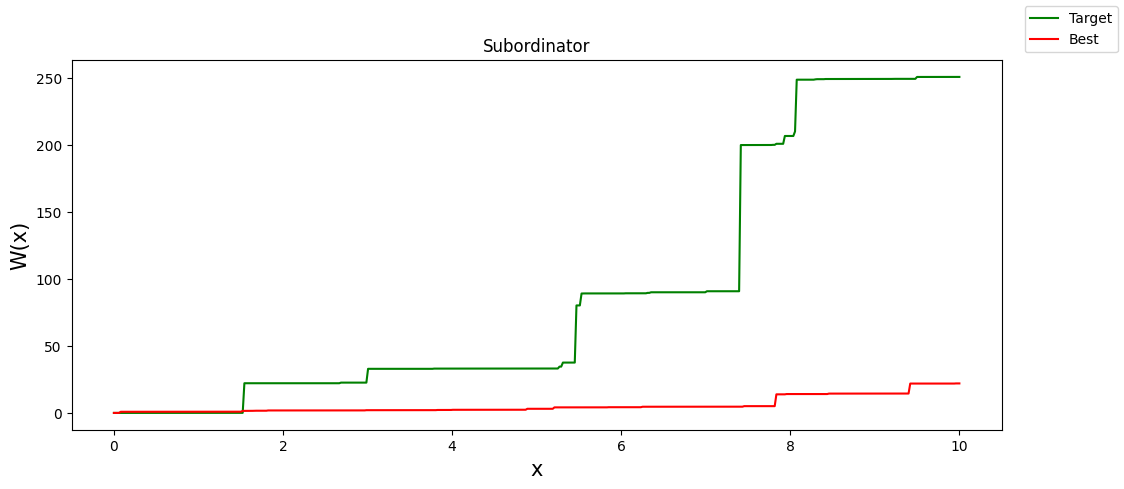

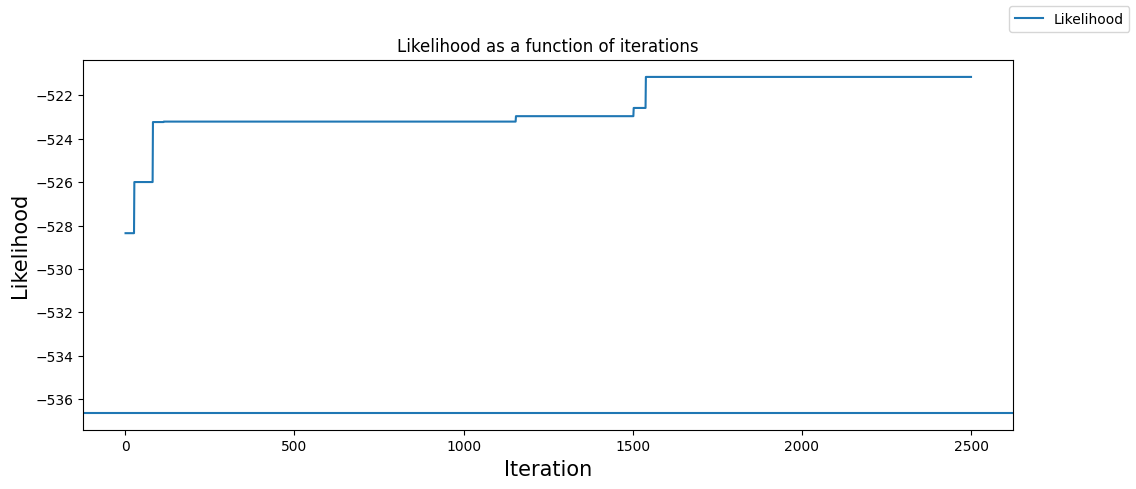

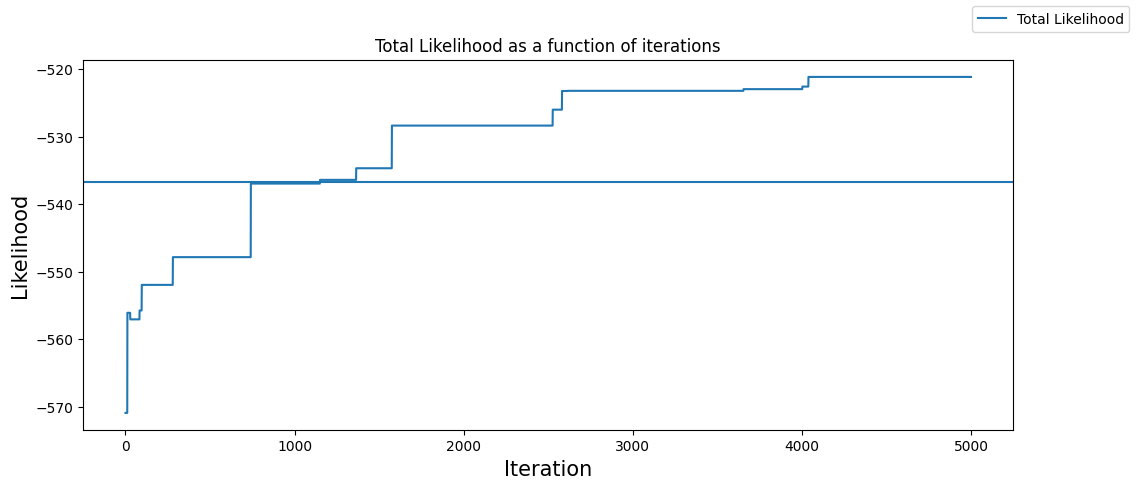

Could not connect to 127.0.0.1: 61081
Traceback (most recent call last):
  File "/private/var/folders/1r/ktdpd4ws5l95ggpj96p1l40w0000gn/T/AppTranslocation/2A310842-6F0A-47C0-881A-6699FB70453A/d/PyCharm.app/Contents/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_comm.py", line 463, in start_client
    s.connect((host, port))
ConnectionRefusedError: [Errno 61] Connection refused
Traceback (most recent call last):
  File "/private/var/folders/1r/ktdpd4ws5l95ggpj96p1l40w0000gn/T/AppTranslocation/2A310842-6F0A-47C0-881A-6699FB70453A/d/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug/pydev_jupyter_utils.py", line 81, in attach_to_debugger
    debugger.connect(pydev_localhost.get_localhost(), debugger_port)
  File "/private/var/folders/1r/ktdpd4ws5l95ggpj96p1l40w0000gn/T/AppTranslocation/2A310842-6F0A-47C0-881A-6699FB70453A/d/PyCharm.app/Contents/plugins/python/helpers/pydev/pydevd.py", line 660, in connect
    s = start_client(host, port)
  File "/private/var/folders/1r/ktdp

Number of accepted likelihood samples: 15
Accepted Likelihood samples: [-527.5033796914348, -526.363973662882, -527.452952271529, -524.464835990524, -523.8019332833883, -528.0147461272973, -530.63892844175, -525.6466271434882, -522.801108251125, -524.4895366738019, -524.467821146146, -523.41146162952, -522.1509014305154, -520.5852597071814, -519.6173252366424]
Accepted Alphas: [2.340240843709757, 3.1249117055112254, 0.33656007776315017, 19.84825871273636, 1.9404166288078681, 0.01480466649921406, 0.072499014200191, 147.27495741602687, 17.210486742508195, 0.1848097386802429, 1.0219530257432408, 2.8758823071906763, 3.5273969782555556, 4.785745074985208, 2.632501330763418]


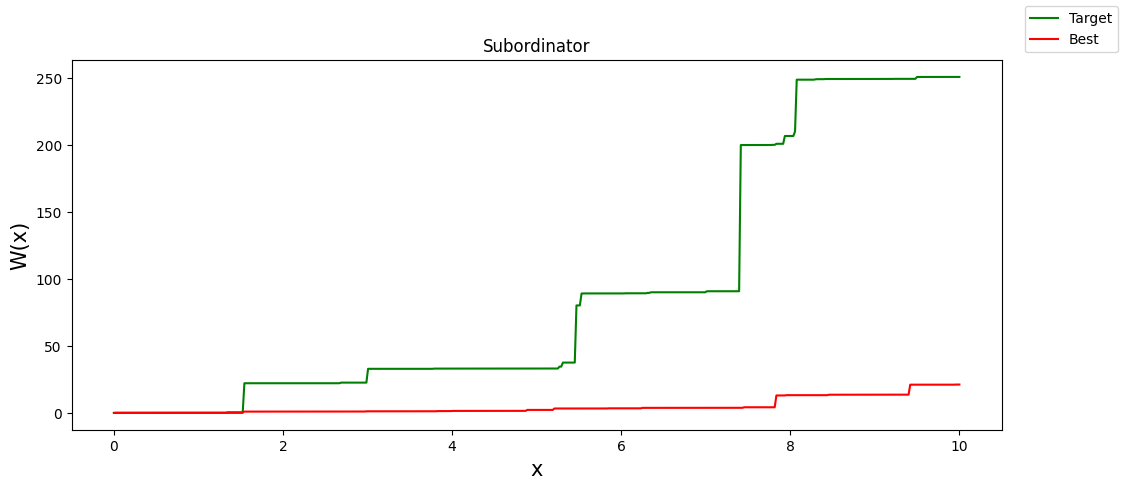

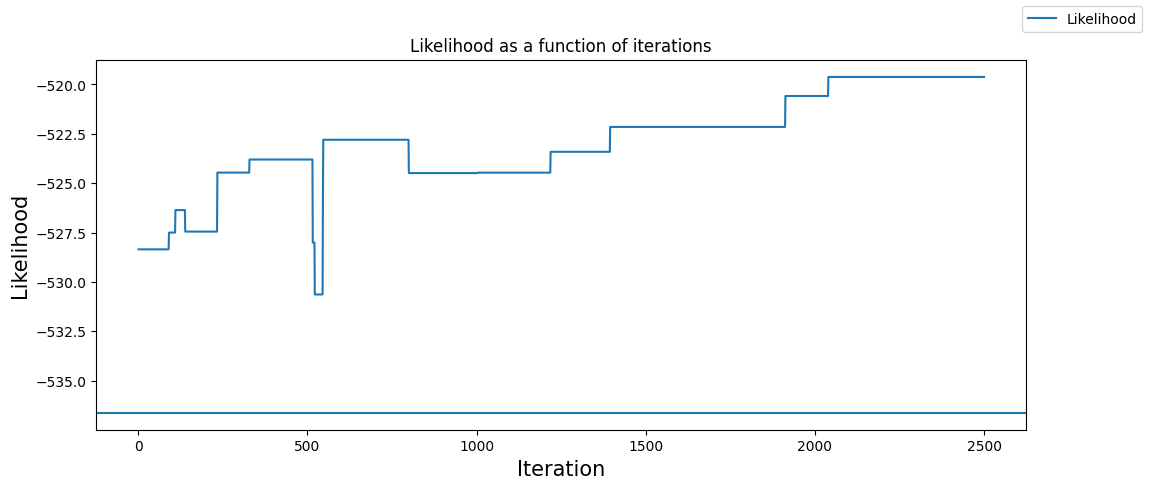

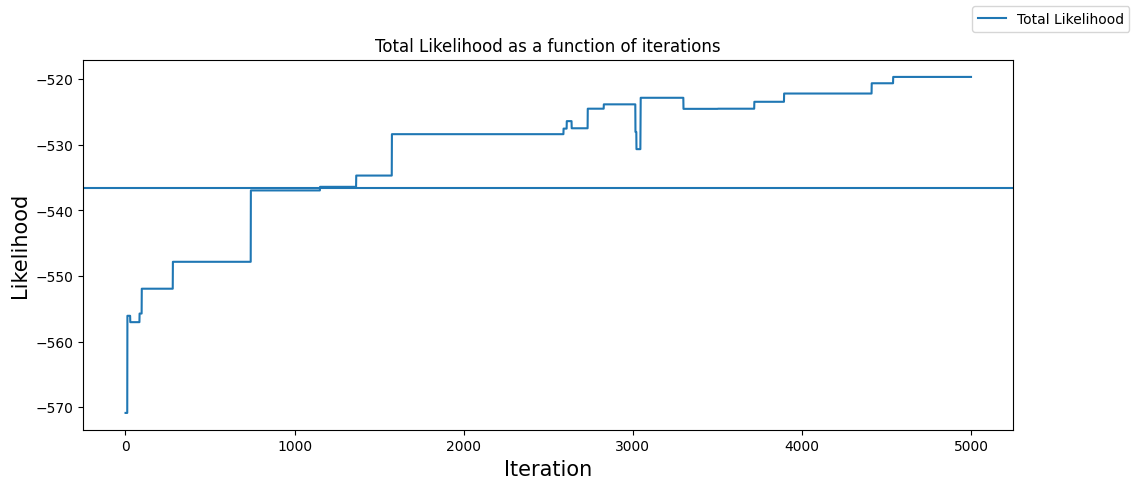

In [13]:
# Run the Metropolis-Hastings algorithm
t1 = 0.0
t2 = 2.5

N = 4

current_sub = accept_sub_samples[-1]

acceptances1 = 0

accept_sub_samples_1 = []

likelihood_samples1 = []
accept_likelihood_samples1 = []

alphas1 = []
accept_alphas1 = []


for i in range(num_iter):
    # Draw a new proposal from the proposal distribution
#     print('Iteration:', i+1)


    new_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
    diff1 = new_sub[-1] - accept_sub_samples[-1][int(num_obs/N)]
    addon1 = accept_sub_samples[-1][int(num_obs/N):] + diff1
    total1 = np.concatenate((new_sub, addon1))


    log_alpha = log_likelihood(total1, Y) - log_likelihood(current_sub, Y)
    alpha = np.exp(log_alpha)

    accept = np.random.uniform() < alpha
    alphas1.append(alpha)

    if accept:
        current_sub = total1

        acceptances1 += 1

        accept_likelihood_samples1.append(log_likelihood(current_sub, Y))

        accept_alphas1.append(alpha)

        accept_sub_samples_1.append(current_sub)

    likelihood_samples1.append(log_likelihood(current_sub, Y))

    
# Print the acceptance rate
#print('Acceptance rate:', acceptances*100 / num_iter, '%')
print('Number of accepted likelihood samples:', acceptances1)
print('Accepted Likelihood samples:', accept_likelihood_samples1)
print('Accepted Alphas:', accept_alphas1)
#print(log_likelihood(X[:250], Y1))

Xs = np.linspace(0, 10, int(num_obs))

#plt.figure(1).set_figwidth(12)
#plt.xlabel('x', fontsize=15)
#plt.ylabel('y(x)', fontsize=15)
#plt.title('Time-Changed Gaussian Process')
#plt.plot(Xs, Y1)


plt.figure(2).set_figwidth(12)
plt.plot(Xs, initial_sub, label='Target', color='green')
plt.plot(Xs, accept_sub_samples_1[-1], label='Best', color='red')
plt.title('Subordinator')
plt.xlabel('x', fontsize=15)
plt.ylabel('W(x)', fontsize=15)
plt.figure(2).legend()

plt.figure(3).set_figwidth(12)
plt.plot(np.linspace(1, len(likelihood_samples1), len(likelihood_samples1)), likelihood_samples1, label='Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(3).legend()

total_likelihood = likelihood_samples + likelihood_samples1

plt.figure(4).set_figwidth(12)
plt.plot(np.linspace(1, len(total_likelihood), len(total_likelihood)), total_likelihood, label='Total Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Total Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(4).legend()


new_sub = TemperedStableSubordinator(2.5, 5.0, 125, num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)

diff2a = accept_sub_samples_1[-1][125]
addon2a = new_sub + diff2a

diff2b = new_sub[-1] - accept_sub_samples_1[-1][250]
addon2b = accept_sub_samples_1[-1][250:] + diff2b + diff2a

total2 = np.concatenate((accept_sub_samples_1[-1][:125], addon2a, addon2b))

print(accept_sub_samples_1[-1][int(num_obs/N)])
print(new_sub[-1])
print(addon2b[0])
print(accept_sub_samples_1[-1][250])
print(new_sub)
plt.figure(1).set_figwidth(12)
plt.plot(np.linspace(2.5, 5.0, 125), addon2a, color='red')
plt.plot(np.linspace(5.0, 10.0, 250), addon2b, color='green')
plt.plot(np.linspace(0, 2.5, 125), accept_sub_samples_1[-1][:125])
plt.plot(np.linspace(0, 5, 250), total2, color='yellow')

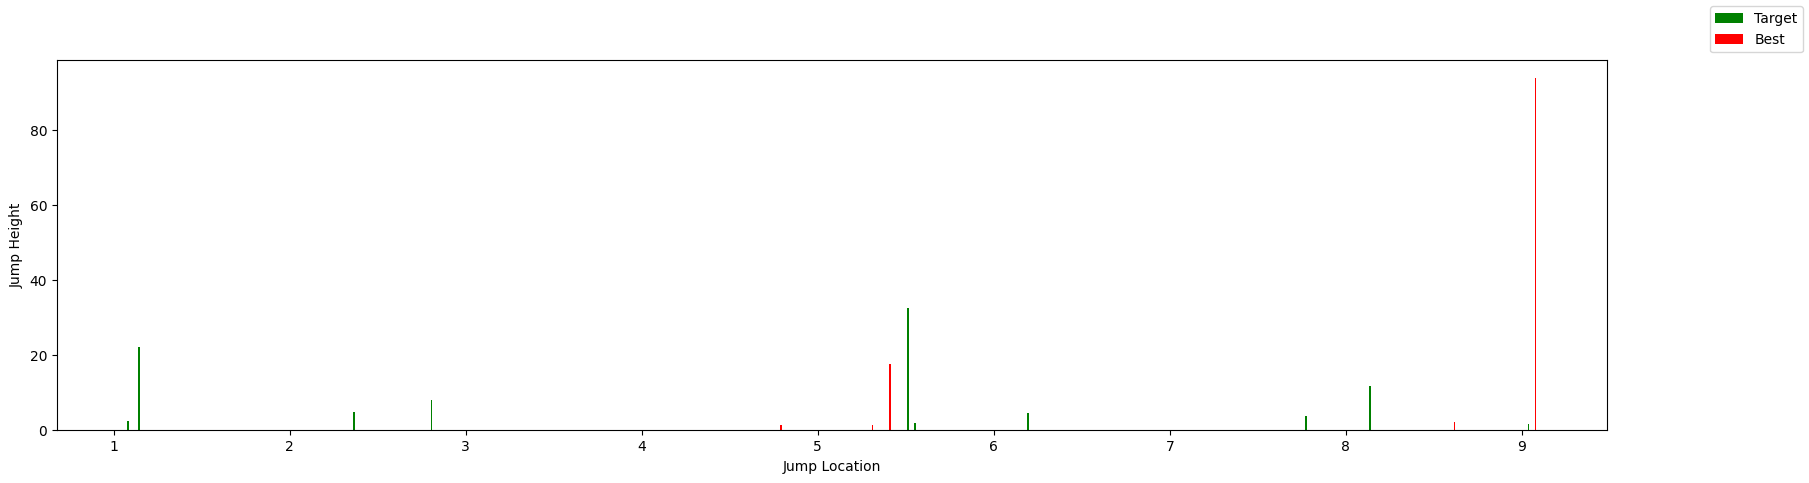

In [33]:
X2_jump= []
Y2_jump= []

length = len(initial_sub)

for i in range(length-1):
    difference = 1
    if accept_sub_samples_1[-1][i+1] - accept_sub_samples_1[-1][i] > difference:
        X2_jump.append(Xs[i])
        Y2_jump.append((accept_sub_samples_1[-1][i+1] - accept_sub_samples_1[-1][i])[0])

plt.figure(3).set_figwidth(20)
plt.bar(X_jump,Y_jump, width = 0.01, color='green', label='Target')
plt.bar(X2_jump,Y2_jump, width = 0.01, color='red', label='Best')
plt.xlabel('Jump Location')
plt.ylabel('Jump Height')
plt.figure(3).legend()

t1 = 5.0
t2 = 10.0

current_sub = TemperedStableSubordinator(t1, t2, int(num_obs/2), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
print(len(current_sub))
print(accept_sub_samples_1[-1][250])
#print(accept_sub_samples[-1][-1])
#print(abs(accept_sub_samples[-1][250]-current_sub[-1]))

diff = accept_sub_samples_1[-1][250]
addon = current_sub + diff
total = np.concatenate((accept_sub_samples_1[-1][:250], addon))

plt.plot(np.linspace(5, 10, int(num_obs/2)), current_sub)
plt.plot(np.linspace(0, 10, int(num_obs)), accept_sub_samples_1[-1])
#plt.plot(np.linspace(5, 10, int(num_obs/2)), accept_sub_samples[-1][250:])
plt.plot(np.linspace(5, 10, int(num_obs/2)), addon)
plt.plot(np.linspace(0, 10, int(num_obs)), total)
plt.show()

Number of accepted likelihood samples: 40
Accepted Likelihood samples: [-511.8480941411771, -509.0625880498631, -507.7098424314992, -508.3487241507384, -505.8685704097099, -506.4337461153026, -507.0817896197032, -506.8766329319149, -505.94360465889855, -507.12757106091254, -507.9570411989893, -506.4776299243483, -507.5915516373511, -507.72329471257876, -507.7504991556166, -510.7328415362965, -510.43254472862077, -510.922306441674, -511.3094698375091, -506.4634787365356, -506.58288433437184, -505.5435762972271, -505.9994537950311, -507.8179048508334, -508.1876164646586, -506.040441091025, -508.66076181962325, -507.05042169937917, -506.2414097611678, -507.1342305118735, -508.75156473326416, -506.9857952712139, -505.8864089350575, -507.822091026333, -508.29838912672386, -508.26836605270546, -509.12812430061604, -507.83339837235843, -506.515754793983, -505.83417311358494]
Accepted Alphas: [0.24877952993444669, 16.20801853884544, 3.8680311018343687, 0.5278824148423776, 11.9431004212534, 0.5

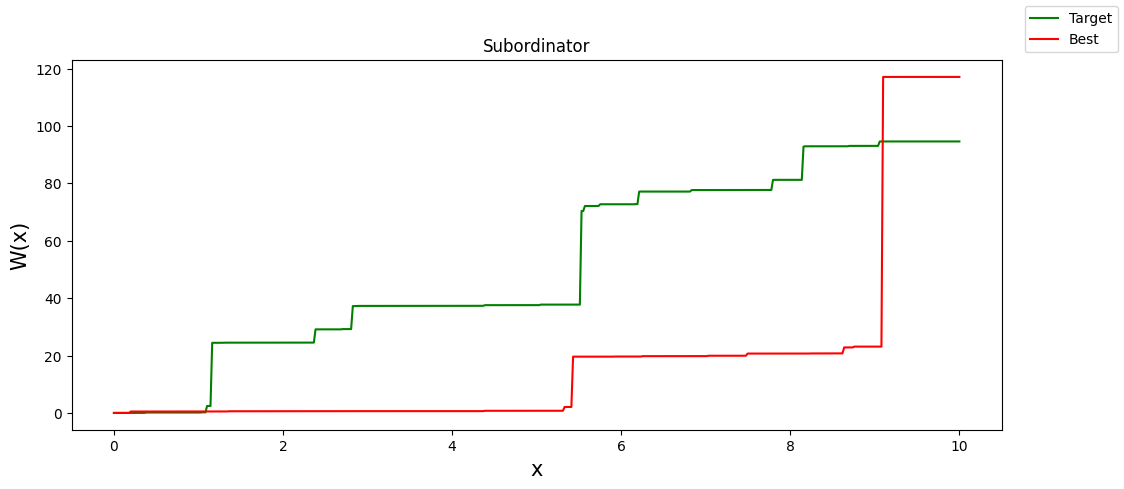

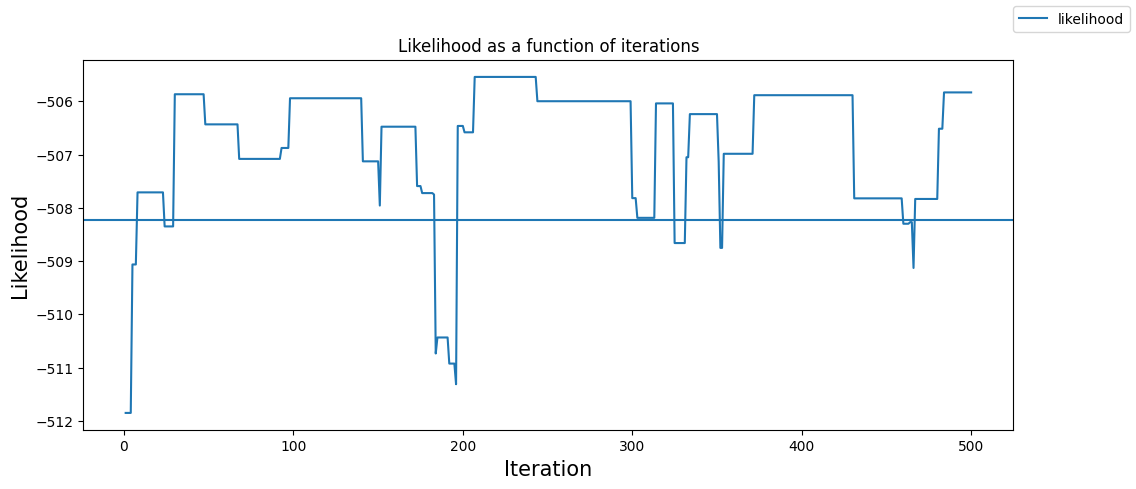

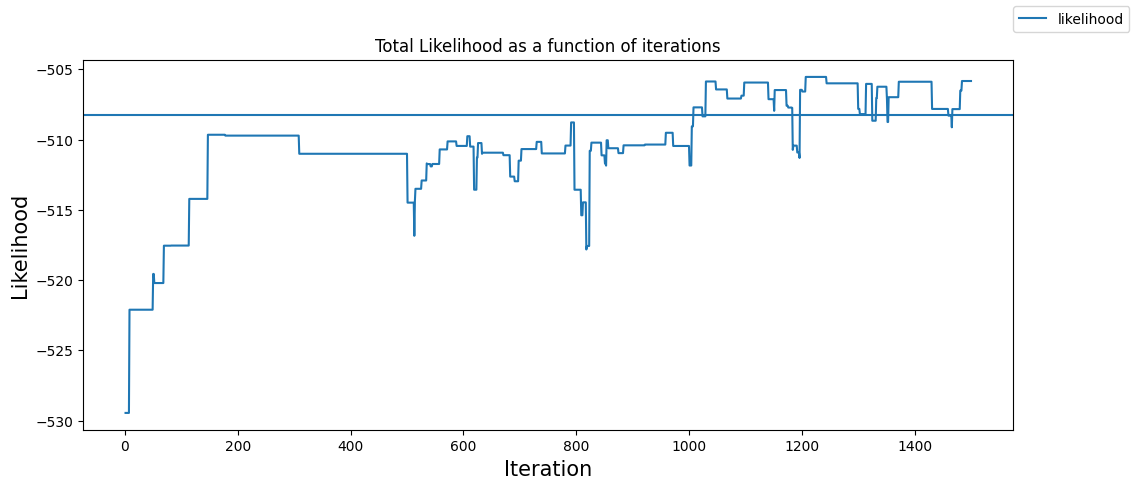

In [10]:
# Run the Metropolis-Hastings algorithm
t1 = 2.5
t2 = 5.0

N = 4

current_sub = accept_sub_samples_1[-1]

acceptances2 = 0

accept_sub_samples_2 = []

likelihood_samples2 = []
accept_likelihood_samples2 = []

alphas2 = []
accept_alphas2 = []


for i in range(num_iter):
    # Draw a new proposal from the proposal distribution
#     print('Iteration:', i+1)

    new_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)

    diff2a = accept_sub_samples_1[-1][int(num_obs/N)]
    addon2a = new_sub + diff2a

    diff2b = new_sub[-1] - accept_sub_samples_1[-1][int(2*num_obs/N)]
    addon2b = accept_sub_samples_1[-1][int(2*num_obs/N):] + diff2b +diff2a

    total2 = np.concatenate((accept_sub_samples_1[-1][:int(num_obs/N)], addon2a, addon2b))

    log_alpha = log_likelihood(total2, Y) - log_likelihood(current_sub, Y)
    alpha = np.exp(log_alpha)

    accept = np.random.uniform() < alpha
    alphas2.append(alpha)

    if accept:
        current_sub = total2

        acceptances2 += 1

        accept_likelihood_samples2.append(log_likelihood(current_sub, Y))

        accept_alphas2.append(alpha)

        accept_sub_samples_2.append(current_sub)

    likelihood_samples2.append(log_likelihood(current_sub, Y))

    
# Print the acceptance rate
#print('Acceptance rate:', acceptances*100 / num_iter, '%')
print('Number of accepted likelihood samples:', acceptances2)
print('Accepted Likelihood samples:', accept_likelihood_samples2)
print('Accepted Alphas:', accept_alphas2)
print(log_likelihood(X, Y))

Xs = np.linspace(0, 10, int(num_obs))

#plt.figure(1).set_figwidth(12)
#plt.xlabel('x', fontsize=15)
#plt.ylabel('y(x)', fontsize=15)
#plt.title('Time-Changed Gaussian Process')
#plt.plot(Xs, Y1)


plt.figure(2).set_figwidth(12)
plt.plot(Xs, initial_sub, label='Target', color='green')
plt.plot(Xs, accept_sub_samples_2[-1], label='Best', color='red')
plt.title('Subordinator')
plt.xlabel('x', fontsize=15)
plt.ylabel('W(x)', fontsize=15)
plt.figure(2).legend()

plt.figure(3).set_figwidth(12)
plt.plot(np.linspace(1, len(likelihood_samples2), len(likelihood_samples2)), likelihood_samples2, label='Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(3).legend()

total_likelihood = likelihood_samples + likelihood_samples1 + likelihood_samples2

plt.figure(4).set_figwidth(12)
plt.plot(np.linspace(1, len(total_likelihood), len(total_likelihood)), total_likelihood, label='Total Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Total Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(4).legend()

In [ ]:
X3_jump= []
Y3_jump= []

length = len(initial_sub)

for i in range(length-1):
    difference = 1
    if accept_sub_samples_2[-1][i+1] - accept_sub_samples_2[-1][i] > difference:
        X3_jump.append(Xs[i])
        Y3_jump.append((accept_sub_samples_2[-1][i+1] - accept_sub_samples_2[-1][i])[0])

plt.figure(3).set_figwidth(20)
plt.bar(X_jump,Y_jump, width = 0.01, color='green', label='Target')
plt.bar(X3_jump,Y3_jump, width = 0.01, color='red', label='Best')
plt.xlabel('Jump Location')
plt.ylabel('Jump Height')
plt.figure(3).legend()

new_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)

diff3a = accept_sub_samples_2[-1][int(2*num_obs/N)]
addon3a = new_sub + diff3a

diff3b = new_sub[-1] - accept_sub_samples_2[-1][int(3*num_obs/N)]
addon3b = accept_sub_samples_2[-1][int(3*num_obs/N):] + diff3b + diff3a

total3 = np.concatenate((accept_sub_samples_2[-1][:int(2*num_obs/N)], addon3a, addon3b))

#print(accept_sub_samples_1[-1][int(num_obs/N)])
#print(new_sub[-1])
#print(addon2b[0])
#print(accept_sub_samples_1[-1][250])
#print(new_sub)

plt.figure(1).set_figwidth(12)
plt.plot(np.linspace(0, 10.0, 500), accept_sub_samples_2[-1], color='red')
plt.plot(np.linspace(5.0, 7.5, 125), addon3a)
plt.plot(np.linspace(7.5, 10.0, 125), addon3b)
plt.plot(np.linspace(0, 5, 250), accept_sub_samples_2[-1][:250])
#plt.plot(np.linspace(0, 5, 250), total3, color=‘yellow’)

Number of accepted likelihood samples: 5
Accepted Likelihood samples: [-497.6832083864865, -497.7103181839911, -497.923032460573, -498.3747169341439, -499.57132446788785]
Accepted Alphas: [0.34584393872939173, 0.973254374755923, 0.8083870793415946, 0.6365549879639455, 0.30221773827032195]
-508.2218994172389


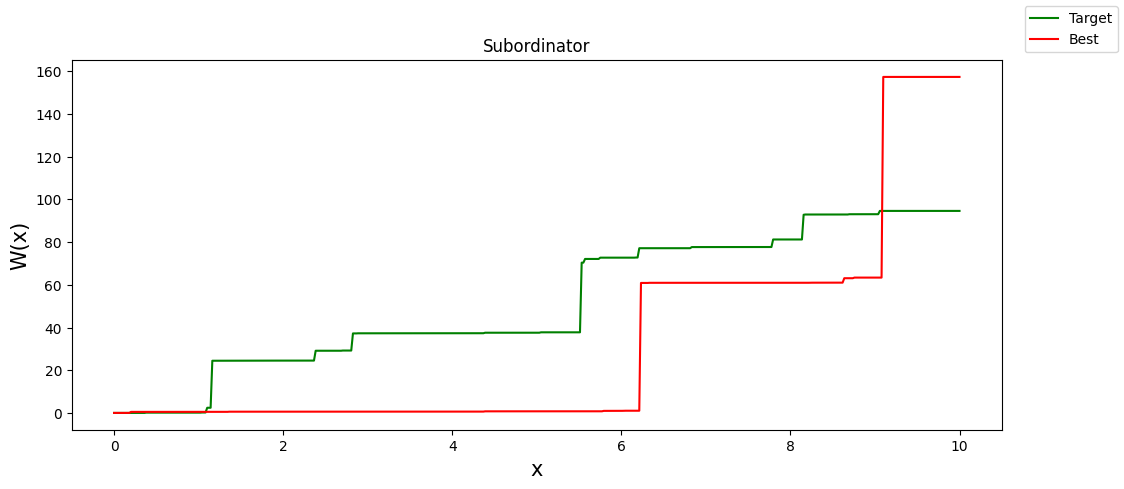

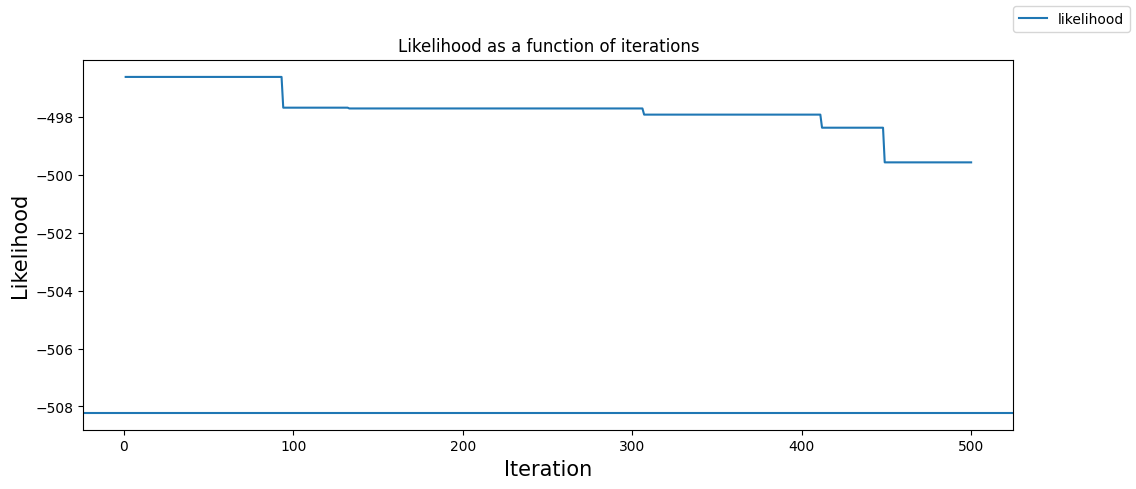

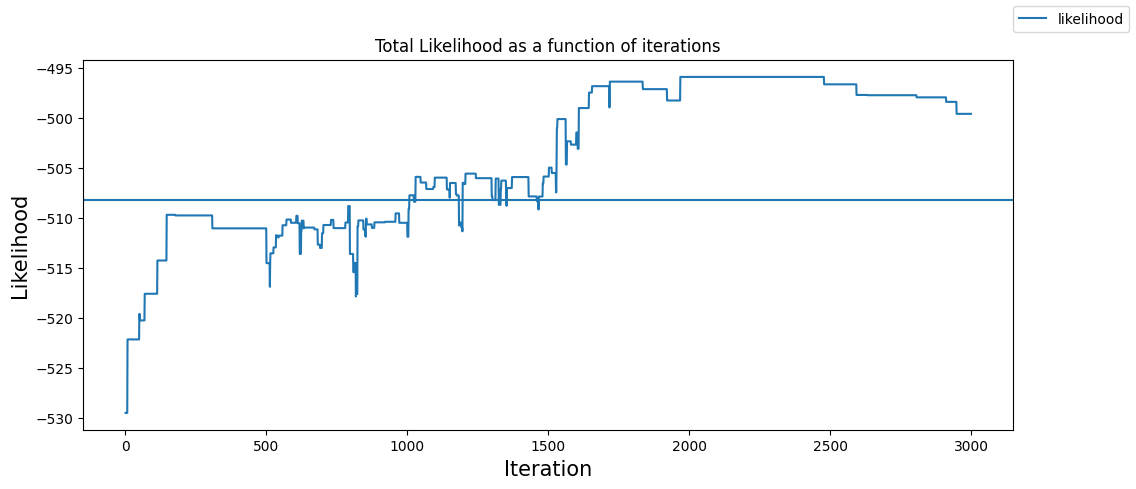

In [21]:
# Run the Metropolis-Hastings algorithm
t1 = 5.0
t2 = 7.5

N = 4

#current_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
#diff3 = accept_sub_samples_1[-1][250]
#addon3 = current_sub + diff3
#total3 = np.concatenate((accept_sub_samples_1[-1][:250], addon3))
current_sub = accept_sub_samples_2[-1]

acceptances3 = 0

accept_sub_samples_3 = []

likelihood_samples3 = []
accept_likelihood_samples3 = []

alphas3 = []
accept_alphas3 = []


for i in range(num_iter):
    # Draw a new proposal from the proposal distribution
#     print('Iteration:', i+1)

    new_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)

    diff3a = accept_sub_samples_2[-1][int(2*num_obs/N)]
    addon3a = new_sub + diff3a

    diff3b = new_sub[-1] - accept_sub_samples_2[-1][int(3*num_obs/N)]
    addon3b = accept_sub_samples_2[-1][int(3*num_obs/N):] + diff3b + diff3a

    total3 = np.concatenate((accept_sub_samples_2[-1][:int(2*num_obs/N)], addon3a, addon3b))

    log_alpha = log_likelihood(total3, Y) - log_likelihood(current_sub, Y)
    alpha = np.exp(log_alpha)

    accept = np.random.uniform() < alpha
    alphas3.append(alpha)

    if accept:
        current_sub = total3

        acceptances3 += 1

        accept_likelihood_samples3.append(log_likelihood(current_sub, Y))

        accept_alphas3.append(alpha)

        accept_sub_samples_3.append(current_sub)

    likelihood_samples3.append(log_likelihood(current_sub, Y))


# Print the acceptance rate
#print('Acceptance rate:', acceptances*100 / num_iter, '%')
print('Number of accepted likelihood samples:', acceptances3)
print('Accepted Likelihood samples:', accept_likelihood_samples3)
print('Accepted Alphas:', accept_alphas3)
print(log_likelihood(X, Y))

Xs = np.linspace(0, 10, int(num_obs))

#plt.figure(1).set_figwidth(12)
#plt.xlabel('x', fontsize=15)
#plt.ylabel('y(x)', fontsize=15)
#plt.title('Time-Changed Gaussian Process')
#plt.plot(Xs, Y1)


plt.figure(2).set_figwidth(12)
plt.plot(Xs, initial_sub, label='Target', color='green')
plt.plot(Xs, accept_sub_samples_3[-1], label='Best', color='red')
plt.title('Subordinator')
plt.xlabel('x', fontsize=15)
plt.ylabel('W(x)', fontsize=15)
plt.figure(2).legend()

plt.figure(3).set_figwidth(12)
plt.plot(np.linspace(1, len(likelihood_samples3), len(likelihood_samples3)), likelihood_samples3, label='Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(3).legend()

total_likelihood = likelihood_samples + likelihood_samples1 + likelihood_samples2 + likelihood_samples3

plt.figure(4).set_figwidth(12)
plt.plot(np.linspace(1, len(total_likelihood), len(total_likelihood)), total_likelihood, label='Total Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Total Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(4).legend()

Text(0, 0.5, 'Jump Height')

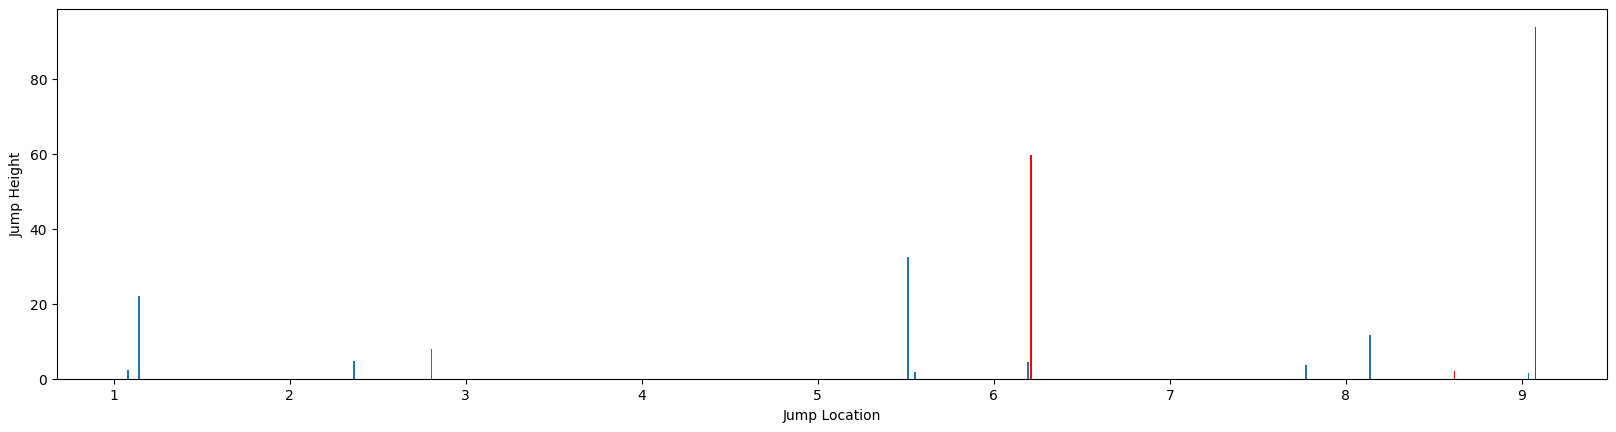

In [22]:
X4_jump= []
Y4_jump= []

length = len(initial_sub)

for i in range(length-1):
    difference = 1
    if accept_sub_samples_3[-1][i+1] - accept_sub_samples_3[-1][i] > difference:
        X4_jump.append(Xs[i])
        Y4_jump.append((accept_sub_samples_3[-1][i+1] - accept_sub_samples_3[-1][i])[0])

plt.figure(3).set_figwidth(20)
plt.bar(X_jump,Y_jump, width = 0.01, color='green', label='Target')
plt.bar(X4_jump,Y4_jump, width = 0.01, color='red', label='Best')
plt.xlabel('Jump Location')
plt.ylabel('Jump Height')
plt.figure(3).legend()

new_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)

diff4 = accept_sub_samples_3[-1][375]
addon4 = new_sub + diff4
total4 = np.concatenate((accept_sub_samples_3[-1][:375], addon4))

plt.figure(1).set_figwidth(12)
plt.plot(np.linspace(0, 10.0, 500), accept_sub_samples_3[-1], color='red')
#plt.plot(np.linspace(5.0, 7.5, 125), addon3a)
plt.plot(np.linspace(7.5, 10.0, 125), addon4)
#plt.plot(np.linspace(0, 5, 250), accept_sub_samples_2[-1][:250])
plt.plot(np.linspace(0, 10, 500), total4, color='yellow')

Number of accepted likelihood samples: 15
Accepted Likelihood samples: [-501.5831501019245, -501.456115601923, -498.72444577364496, -498.8010417581298, -498.21657843371435, -495.52639312296367, -495.23268956725576, -499.5187679417946, -498.50406787769583, -495.88421995831726, -498.709433254056, -498.24483126131014, -499.8935074899333, -501.8208102671216, -495.9017996713533]
Accepted Alphas: [0.1337442835360669, 1.1354561903460418, 15.358511696687655, 0.9262640030486562, 1.7940279162545028, 14.734406111325184, 1.341386198439142, 0.013758776404275362, 2.758535889334694, 13.733634806534731, 0.059296007894695156, 1.591380681769845, 0.19230430713829624, 0.14554022396802654, 372.0434303712211]
-508.2218994172389


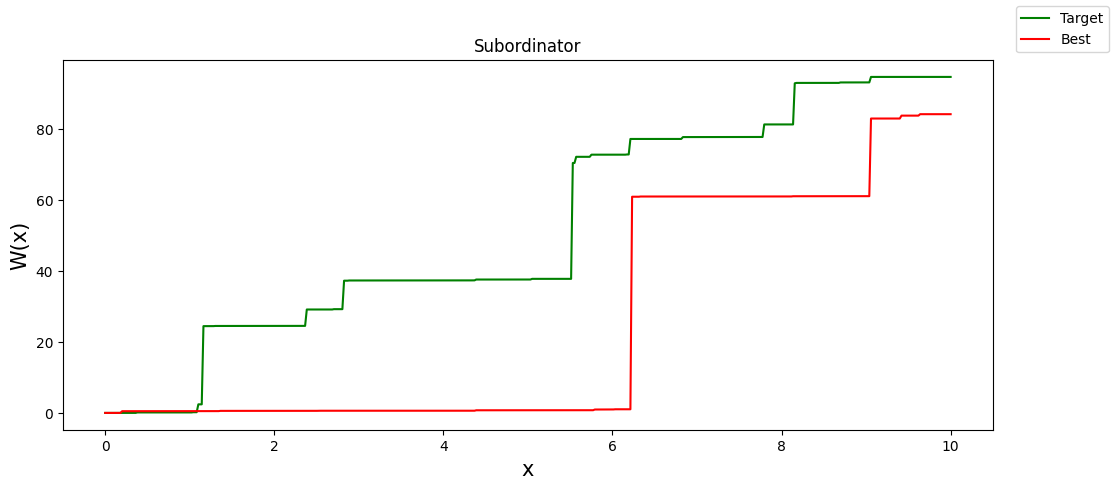

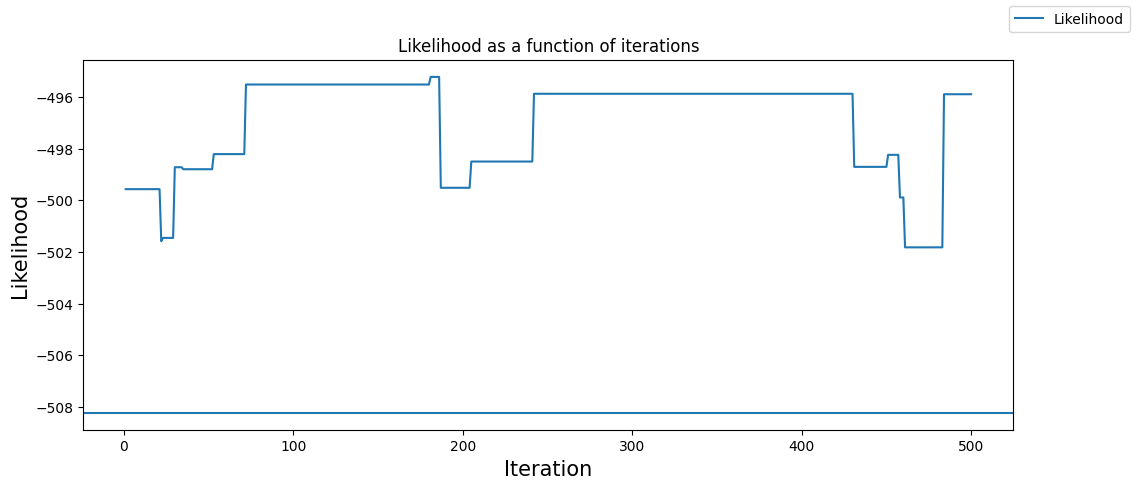

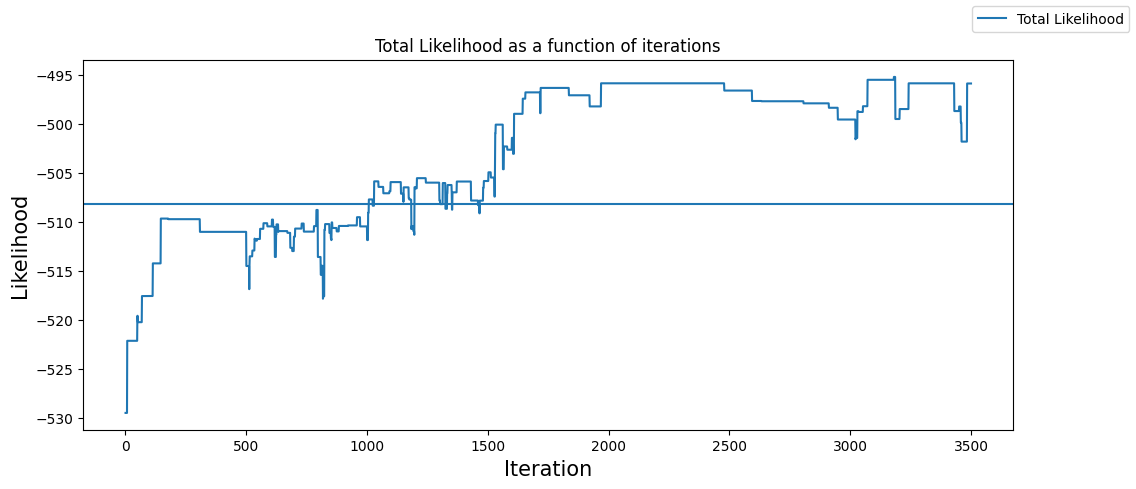

In [31]:
# Run the Metropolis-Hastings algorithm
t1 = 7.5
t2 = 10.0

N = 4

#current_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
#diff3 = accept_sub_samples_1[-1][250]
#addon3 = current_sub + diff3
#total3 = np.concatenate((accept_sub_samples_1[-1][:250], addon3))
current_sub = accept_sub_samples_3[-1]

acceptances4 = 0

accept_sub_samples_4 = []

likelihood_samples4 = []
accept_likelihood_samples4 = []

alphas4 = []
accept_alphas4 = []


for i in range(num_iter):
    # Draw a new proposal from the proposal distribution
#     print('Iteration:', i+1)

    new_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)

    diff4 = accept_sub_samples_3[-1][375]
    addon4 = new_sub + diff4
    total4 = np.concatenate((accept_sub_samples_3[-1][:375], addon4))

    log_alpha = log_likelihood(total4, Y) - log_likelihood(current_sub, Y)

    alpha = np.exp(log_alpha)

    accept = np.random.uniform() < alpha
    alphas4.append(alpha)

    if accept:
        current_sub = total4

        acceptances4 += 1

        accept_likelihood_samples4.append(log_likelihood(current_sub, Y))

        accept_alphas4.append(alpha)

        accept_sub_samples_4.append(current_sub)

    likelihood_samples4.append(log_likelihood(current_sub, Y))


# Print the acceptance rate
#print('Acceptance rate:', acceptances*100 / num_iter, '%')
print('Number of accepted likelihood samples:', acceptances4)
print('Accepted Likelihood samples:', accept_likelihood_samples4)
print('Accepted Alphas:', accept_alphas4)
print(log_likelihood(X, Y))

Xs = np.linspace(0, 10, int(num_obs))

#plt.figure(1).set_figwidth(12)
#plt.xlabel('x', fontsize=15)
#plt.ylabel('y(x)', fontsize=15)
#plt.title('Time-Changed Gaussian Process')
#plt.plot(Xs, Y1)


plt.figure(2).set_figwidth(12)
plt.plot(Xs, initial_sub, label='Target', color='green')
plt.plot(Xs, accept_sub_samples_4[-1], label='Best', color='red')
plt.title('Subordinator')
plt.xlabel('x', fontsize=15)
plt.ylabel('W(x)', fontsize=15)
plt.figure(2).legend()

plt.figure(3).set_figwidth(12)
plt.plot(np.linspace(1, len(likelihood_samples4), len(likelihood_samples4)), likelihood_samples4, label='Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(3).legend()

total_likelihood = likelihood_samples + likelihood_samples1 + likelihood_samples2 + likelihood_samples3 + likelihood_samples4

plt.figure(4).set_figwidth(12)
plt.plot(np.linspace(1, len(total_likelihood), len(total_likelihood)), total_likelihood, label='Total Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Total Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(4).legend()

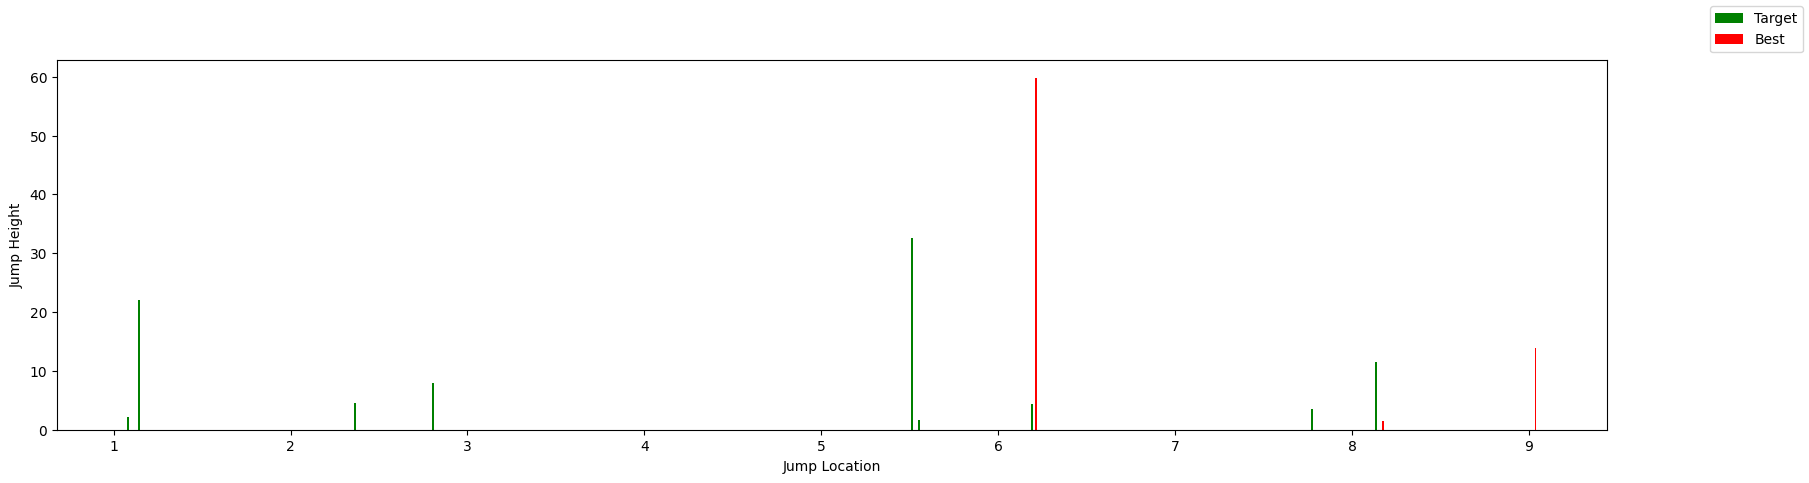

In [30]:
X5_jump= []
Y5_jump= []

length = len(initial_sub)

for i in range(length-1):
    difference = 1
    if accept_sub_samples_4[-1][i+1] - accept_sub_samples_4[-1][i] > difference:
        X5_jump.append(Xs[i])
        Y5_jump.append((accept_sub_samples_4[-1][i+1] - accept_sub_samples_4[-1][i])[0])

plt.figure(3).set_figwidth(20)
plt.bar(X_jump,Y_jump, width = 0.01, color='green', label='Target')
plt.bar(X5_jump,Y5_jump, width = 0.01, color='red', label='Best')
plt.xlabel('Jump Location')
plt.ylabel('Jump Height')
plt.figure(3).legend()

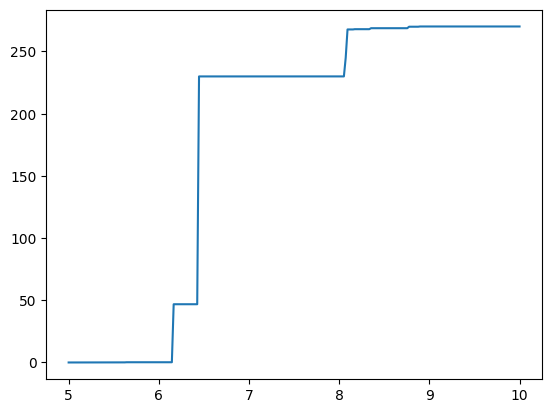

In [28]:
Z = new_sub = TemperedStableSubordinator(5, 10, 250, num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
Z1 = GaussianProcess(initial_sub, 1, num_obs).reshape(-1,1)
plt.plot(np.linspace(5,10,250), Z)
#plt.plot(Xs, Z1)